This notebook demonstrates the addition of environmental noise to the simulated genetic values to produce final phenotypes, offering two approaches: user-defined noise with explicit mean and covariance parameters, or heritability-based noise where the environmental variance is automatically scaled based on a specified h² value (demonstrated with h² = [0.25, 0.5]). Throughout the workflow, it normalizes the data, splits phenotypes by causal mutation, and validates the results through variance calculations and histograms to confirm that the simulated noise and phenotypes match the expected statistical properties.

In [ ]:
import numpy as np
import pygrgl
import matplotlib.pyplot as plt

from grg_pheno_sim.effect_size import sim_grg_causal_mutation, additive_effect_sizes, samples_to_individuals, normalize_genetic_values
from grg_pheno_sim.model import grg_causal_mutation_model
from grg_pheno_sim.noise_sim import sim_env_noise
from grg_pheno_sim.normalization import normalize
from grg_pheno_sim.split import split_phenotypes


The following command only serves the purpose of converting the VCF zip file into a GRG that will be used for the phenotype simulation. The bash script below will function as expected given the relative path for the source data file is accurate.

In [2]:
%%script bash --out /dev/null
if [ ! -f test-200-samples.grg ]; then
  grg construct -p 10 ../data/test-200-samples.vcf.gz --out-file test-200-samples.grg
fi

In [3]:
grg_1 = pygrgl.load_immutable_grg("test-200-samples.grg") #loading in a sample grg stored in the same directory


In [4]:
rng = np.random.default_rng()

mean_1 = np.zeros(2)
cov_1 = np.eye(2) 
model_normal_multi = grg_causal_mutation_model("multivariate normal", mean=mean_1, cov=cov_1)

#simulating effect sizes using just the model
num_causal = 1000  #number of causal sites

effect_sizes = model_normal_multi.sim_effect_size(num_causal, rng)

print("Simulated Effect Sizes:", effect_sizes)

Simulated Effect Sizes: [[-1.20352264  0.23948975]
 [ 1.27174266 -0.74620519]
 [-1.46434558  0.25177634]
 ...
 [ 0.00500196  0.76228927]
 [-1.36975248  0.25229039]
 [-0.82368994  1.85518251]]


In [5]:
trait_df_normal_multi = sim_grg_causal_mutation(grg_1, num_causal=num_causal, model=model_normal_multi, random_seed=1)
sample_nodes_df_multi = additive_effect_sizes(grg_1, trait_df_normal_multi)
individuals = samples_to_individuals(sample_nodes_df_multi)
normalized_individual_multi_normal = normalize_genetic_values(individuals)


First, we will demonstrate how to simulate user-defined noise for multiple causal mutations (if the user does not want to use the h2 heritability feature). In this case, the user must specify the mean and covariance matrix to be used.

In [6]:
std_means = np.array([0, 0])
std_covariances = np.array([[1, 0], [0, 1]])
phenotypes_user_defined_multi_normal = sim_env_noise(individuals, user_defined=True, means=std_means, cov=std_covariances) #simulates noise from the multivariate standard normal distribution with means of zero and an identity matrix for covariance
phenotypes_user_defined_multi_normal_df = phenotypes_user_defined_multi_normal.phenotype_df
phenotypes_user_defined_multi_normal_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,-1.107707,-39.050086
1,1,0,-23.087706,0.182788,-22.904918
2,0,1,-19.908226,0.443469,-19.464757
3,1,1,-22.240029,-0.847027,-23.087056
4,0,2,-9.933216,-1.240165,-11.173382
...,...,...,...,...,...
395,1,197,6.632294,0.924280,7.556575
396,0,198,-28.121344,-0.716447,-28.837791
397,1,198,-17.527029,0.350987,-17.176042
398,0,199,-10.601552,-0.242729,-10.844281


The user can extract the h2 assigned to any phenotype simulation as follows.

In [7]:
user_defined_multi_h2 = phenotypes_user_defined_multi_normal.get_h2()
print(user_defined_multi_h2)

[1.00029479 0.9930305 ]


In [8]:
split_phenotypes(phenotypes_user_defined_multi_normal_df, return_print=True)

     causal_mutation_id  individual_id  genetic_value  environmental_noise  \
0                     0              0     -37.942379            -1.107707   
2                     0              1     -19.908226             0.443469   
4                     0              2      -9.933216            -1.240165   
6                     0              3     -16.476328             1.411799   
8                     0              4     -39.004838             2.612507   
..                  ...            ...            ...                  ...   
390                   0            195     -20.002154            -0.826351   
392                   0            196     -27.360933            -0.867529   
394                   0            197     -23.888838            -0.442651   
396                   0            198     -28.121344            -0.716447   
398                   0            199     -10.601552            -0.242729   

     phenotype  
0   -39.050086  
2   -19.464757  
4   -11.1733

In [9]:
split_phenotypes_list = split_phenotypes(phenotypes_user_defined_multi_normal_df, return_list=True)
split_phenotypes_list[0] #the first dataframe

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,-1.107707,-39.050086
2,0,1,-19.908226,0.443469,-19.464757
4,0,2,-9.933216,-1.240165,-11.173382
6,0,3,-16.476328,1.411799,-15.064529
8,0,4,-39.004838,2.612507,-36.392331
...,...,...,...,...,...
390,0,195,-20.002154,-0.826351,-20.828505
392,0,196,-27.360933,-0.867529,-28.228461
394,0,197,-23.888838,-0.442651,-24.331489
396,0,198,-28.121344,-0.716447,-28.837791


In [10]:
split_phenotypes_list[1] #the second dataframe

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
1,1,0,-23.087706,0.182788,-22.904918
3,1,1,-22.240029,-0.847027,-23.087056
5,1,2,-30.900956,-2.021770,-32.922726
7,1,3,-27.909054,0.200954,-27.708100
9,1,4,10.082859,1.252835,11.335694
...,...,...,...,...,...
391,1,195,0.216175,-0.197688,0.018487
393,1,196,-26.683542,-1.398445,-28.081987
395,1,197,6.632294,0.924280,7.556575
397,1,198,-17.527029,0.350987,-17.176042


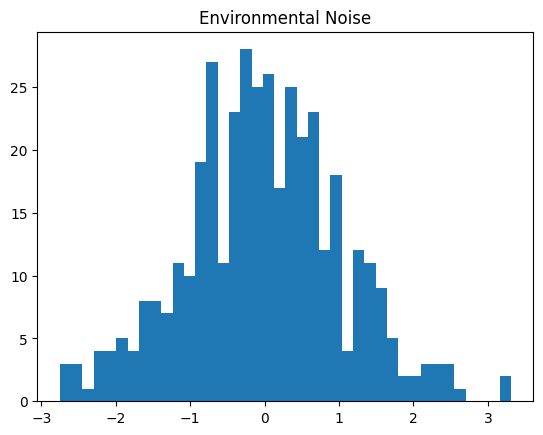

Mean of noise: -0.012409937367291228
Standard deviation of noise: 1.0535873405421528


In [11]:

plt.hist(phenotypes_user_defined_multi_normal_df["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotypes_user_defined_multi_normal_df['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotypes_user_defined_multi_normal_df['environmental_noise'].std()))

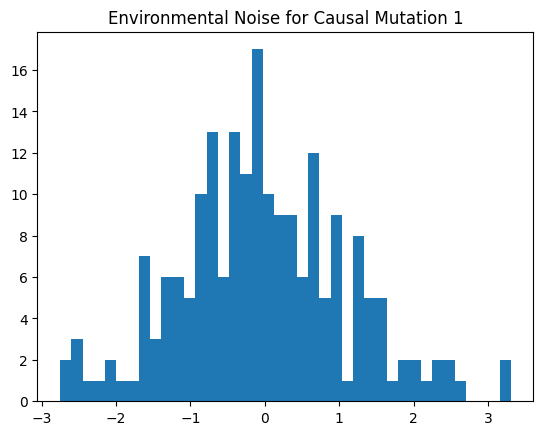

Mean of noise: -0.02792349428435597
Standard deviation of noise: 1.1336773208762438


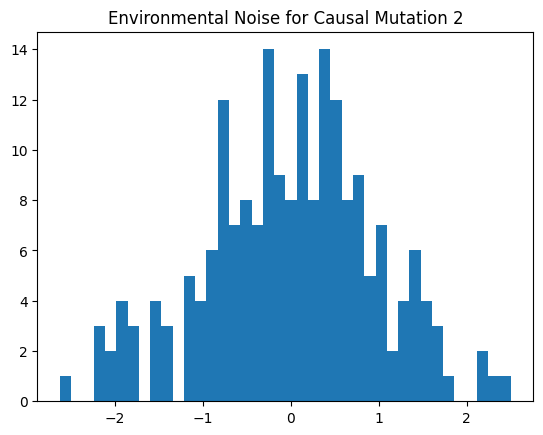

Mean of noise: 0.0031036195497735086
Standard deviation of noise: 0.969516716084993


In [12]:
df_dict_test = {k: v.sort_values('individual_id') for k, v in phenotypes_user_defined_multi_normal_df.groupby('causal_mutation_id')}

num = len(df_dict_test)

for i in range(num):
  temp_df = df_dict_test[i]
  plt.hist(temp_df["environmental_noise"], bins=40)
  plt.title("Environmental Noise for Causal Mutation " + str(i+1) )
  plt.show()
  print("Mean of noise: " + str(temp_df['environmental_noise'].mean()))
  print("Standard deviation of noise: " + str(temp_df['environmental_noise'].std()))

In [13]:
phenotypes_user_defined_multi_normal_df_normalized = normalize(phenotypes_user_defined_multi_normal)
phenotypes_user_defined_multi_normal_df_normalized

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-1.464479,-0.102448,-1.566927
1,1,0,-0.973510,0.015000,-0.958510
2,0,1,0.246567,0.044725,0.291292
3,1,1,-0.902746,-0.070969,-0.973714
4,0,2,1.192977,-0.115015,1.077961
...,...,...,...,...,...
395,1,197,1.507512,0.076900,1.584412
396,0,198,-0.532678,-0.065326,-0.598004
397,1,198,-0.509305,0.029041,-0.480264
398,0,199,1.129566,-0.020380,1.109186


In [14]:
means = np.array([0, 0])
covariance = np.array([[1, 0.25], [0.25, 1]])
phenotypes_user_defined_multi_normal_special_cov = sim_env_noise(individuals, user_defined=True, means=means, cov=covariance) #simulating noise using a user-defined covariance matrix instead of the identity matrix
phenotypes_user_defined_multi_normal_special_cov_df = phenotypes_user_defined_multi_normal_special_cov.phenotype_df
phenotypes_user_defined_multi_normal_special_cov_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,-0.861053,-38.803432
1,1,0,-23.087706,0.750811,-22.336895
2,0,1,-19.908226,0.650723,-19.257503
3,1,1,-22.240029,1.728042,-20.511987
4,0,2,-9.933216,-0.431347,-10.364563
...,...,...,...,...,...
395,1,197,6.632294,1.694549,8.326844
396,0,198,-28.121344,-0.441667,-28.563011
397,1,198,-17.527029,0.321617,-17.205412
398,0,199,-10.601552,0.464860,-10.136693


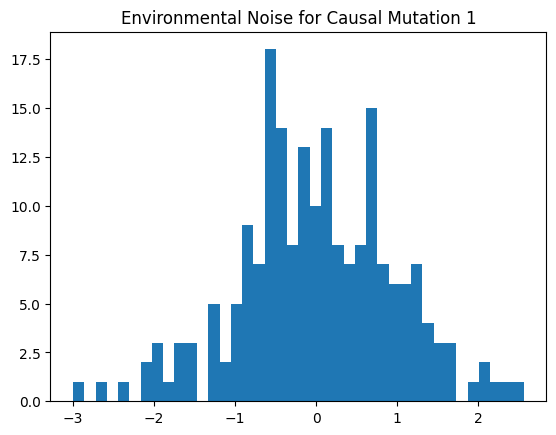

Mean of noise: -0.004253793854578991
Standard deviation of noise: 0.9700195530416899


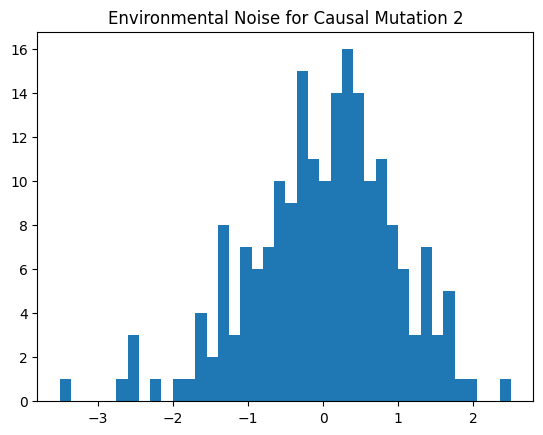

Mean of noise: 0.001499916756001589
Standard deviation of noise: 0.972750241331472


In [15]:
df_dict_test_cov = {k: v.sort_values('individual_id') for k, v in phenotypes_user_defined_multi_normal_special_cov_df.groupby('causal_mutation_id')}

num = len(df_dict_test_cov)

for i in range(num):
  temp_df = df_dict_test_cov[i]
  plt.hist(temp_df["environmental_noise"], bins=40)
  plt.title("Environmental Noise for Causal Mutation " + str(i+1) )
  plt.show()
  print("Mean of noise: " + str(temp_df['environmental_noise'].mean()))
  print("Standard deviation of noise: " + str(temp_df['environmental_noise'].std()))

In [16]:
phenotypes_user_defined_multi_normal_special_cov_df_normalized = normalize(phenotypes_user_defined_multi_normal_special_cov, normalize_genetic_values=True)
phenotypes_user_defined_multi_normal_special_cov_df_normalized

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-1.463421,-0.081233,-1.544653
1,1,0,-0.981200,0.063047,-0.918154
2,0,1,0.246389,0.062098,0.308487
3,1,1,-0.909877,0.145270,-0.764607
4,0,2,1.192114,-0.040493,1.151622
...,...,...,...,...,...
395,1,197,1.519422,0.142452,1.661874
396,0,198,-0.532293,-0.041471,-0.573764
397,1,198,-0.513329,0.026934,-0.486394
398,0,199,1.128750,0.044476,1.173226


In [17]:
phenotypes_zero_noise = sim_env_noise(individuals) #simulates zero noise (assumes h2 is an array of 1s)
phenotypes_zero_noise_df = phenotypes_zero_noise.phenotype_df
phenotypes_zero_noise_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,0.0,-37.942379
1,1,0,-23.087706,0.0,-23.087706
2,0,1,-19.908226,0.0,-19.908226
3,1,1,-22.240029,0.0,-22.240029
4,0,2,-9.933216,0.0,-9.933216
...,...,...,...,...,...
395,1,197,6.632294,0.0,6.632294
396,0,198,-28.121344,0.0,-28.121344
397,1,198,-17.527029,0.0,-17.527029
398,0,199,-10.601552,0.0,-10.601552


Now, we show the usage of the narrow-sense heritability feature to simulate noise for multiple causal mutations (for a dataframe where genetic values have not yet been normalized).

In [18]:
phenotype_multi_normal_h2 = sim_env_noise(individuals, h2=[0.5, 0.75]) #simulating environmental noise for 2 causal mutations without normalizing genetic values
phenotype_multi_normal_h2_df = phenotype_multi_normal_h2.phenotype_df
phenotype_multi_normal_h2_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,-12.365109,-50.307489
1,1,0,-23.087706,15.430866,-7.656840
2,0,1,-19.908226,10.895580,-9.012646
3,1,1,-22.240029,-4.333335,-26.573364
4,0,2,-9.933216,9.077246,-0.855970
...,...,...,...,...,...
395,1,197,6.632294,6.125123,12.757418
396,0,198,-28.121344,1.080543,-27.040801
397,1,198,-17.527029,13.073634,-4.453395
398,0,199,-10.601552,9.294103,-1.307450


In [19]:
print(phenotype_multi_normal_h2.get_h2()) #printing the h2 used for the simulation

[0.5, 0.75]


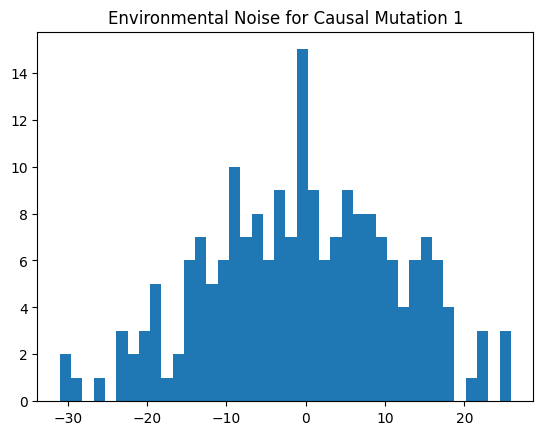

Mean of noise: -0.42871197859918597
Standard deviation of noise: 11.816134240356359


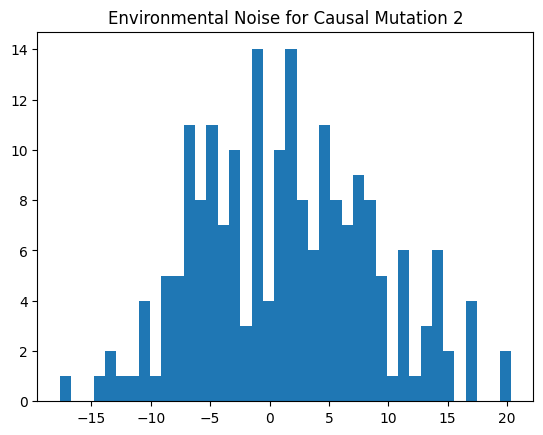

Mean of noise: 1.4609958746664211
Standard deviation of noise: 7.374312412598823


In [20]:
df_dict_test_pre_normal = {k: v.sort_values('individual_id') for k, v in phenotype_multi_normal_h2_df.groupby('causal_mutation_id')}

num = len(df_dict_test_pre_normal)

for i in range(num):
  temp_df = df_dict_test_pre_normal[i]
  plt.hist(temp_df["environmental_noise"], bins=40)
  plt.title("Environmental Noise for Causal Mutation " + str(i+1) )
  plt.show()
  print("Mean of noise: " + str(temp_df['environmental_noise'].mean()))
  print("Standard deviation of noise: " + str(temp_df['environmental_noise'].std()))

In [21]:
phenotype_multi_normal_h2_df_normalized = normalize(phenotype_multi_normal_h2, normalize_genetic_values=True)
phenotype_multi_normal_h2_df_normalized

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.932302,-0.720962,-1.653264
1,1,0,-0.849909,1.018137,0.168228
2,0,1,0.156967,0.683991,0.840958
3,1,1,-0.788130,-0.422296,-1.210426
4,0,2,0.759461,0.574163,1.333624
...,...,...,...,...,...
395,1,197,1.316113,0.339926,1.656039
396,0,198,-0.339108,0.091160,-0.247949
397,1,198,-0.444642,0.846340,0.401698
398,0,199,0.719093,0.587261,1.306354


In [22]:
df_dict_test_pre_normal_final = {k: v.sort_values('individual_id') for k, v in phenotype_multi_normal_h2_df_normalized.groupby('causal_mutation_id')}

num = len(df_dict_test_pre_normal_final)

for i in range(num):
  temp_df = df_dict_test_pre_normal_final[i]
  print("Variance of the phenotypes for Causal Mutation " + str(i+1) + " is "  + str(temp_df['phenotype'].var()))
  print("Variance of the genetic values for Causal Mutation " + str(i+1) + " is "  + str(temp_df['genetic_value'].var()))
  print("Variance of the noise for Causal Mutation " + str(i+1) + " is "  + str(temp_df['environmental_noise'].var()))

Variance of the phenotypes for Causal Mutation 1 is 0.9999999999999997
Variance of the genetic values for Causal Mutation 1 is 0.40070306671823774
Variance of the noise for Causal Mutation 1 is 0.5093654736258278
Variance of the phenotypes for Causal Mutation 2 is 1.0
Variance of the genetic values for Causal Mutation 2 is 0.7518873140478411
Variance of the noise for Causal Mutation 2 is 0.28884915110433734


Now, we show the usage of the narrow-sense heritability feature to simulate noise for multiple causal mutations (for a dataframe where genetic values have already been normalized).

In [23]:
phenotype_post_normalization = sim_env_noise(normalized_individual_multi_normal, h2=[0.25, 0.45]) #simulating noise after genetic values have been normalized
phenotype_df_post_normalization = phenotype_post_normalization.phenotype_df
phenotype_df_post_normalization

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-1.472805,0.460469,-1.012336
1,1,0,-0.980158,1.691067,0.710909
2,0,1,0.247969,2.462775,2.710743
3,1,1,-0.908911,0.072495,-0.836416
4,0,2,1.199759,-2.771596,-1.571837
...,...,...,...,...,...
395,1,197,1.517808,-0.230086,1.287721
396,0,198,-0.535707,-0.877980,-1.413686
397,1,198,-0.512783,1.644249,1.131466
398,0,199,1.135988,3.119494,4.255482


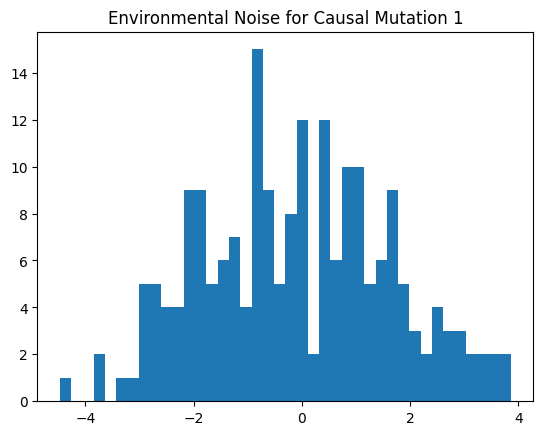

Mean of noise: -0.08638827563387103
Standard deviation of noise: 1.7323926187475045


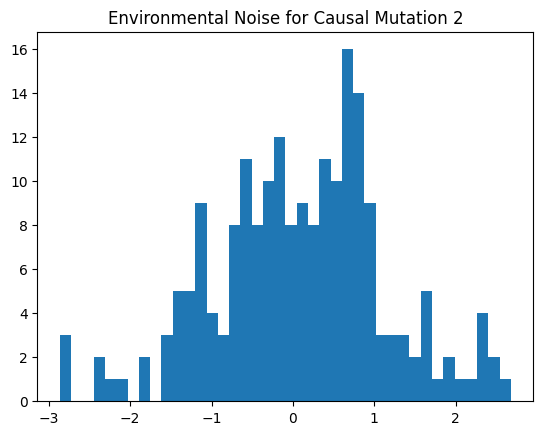

Mean of noise: 0.07708326151503032
Standard deviation of noise: 1.0610095404832423


In [24]:
df_dict_test_post_normal = {k: v.sort_values('individual_id') for k, v in phenotype_df_post_normalization.groupby('causal_mutation_id')}

num = len(df_dict_test_post_normal)

for i in range(num):
  temp_df = df_dict_test_post_normal[i]
  plt.hist(temp_df["environmental_noise"], bins=40)
  plt.title("Environmental Noise for Causal Mutation " + str(i+1) )
  plt.show()
  print("Mean of noise: " + str(temp_df['environmental_noise'].mean()))
  print("Standard deviation of noise: " + str(temp_df['environmental_noise'].std()))

In [25]:
phenotype_post_normalization_final_df = normalize(phenotype_post_normalization) #normalizing the final dataframe with the phenotypes
phenotype_post_normalization_final_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.805396,0.299046,-0.506350
1,1,0,-0.664077,1.093507,0.429430
2,0,1,0.135600,1.393996,1.529597
3,1,1,-0.615806,-0.003109,-0.618914
4,0,2,0.656082,-1.468392,-0.812310
...,...,...,...,...,...
395,1,197,1.028346,-0.208114,0.820232
396,0,198,-0.292948,-0.432878,-0.725826
397,1,198,-0.347421,1.061787,0.714366
398,0,199,0.621209,1.753120,2.374329


In [26]:
df_dict_test_post_normal_final = {k: v.sort_values('individual_id') for k, v in phenotype_post_normalization_final_df.groupby('causal_mutation_id')}

num = len(df_dict_test_post_normal_final)

for i in range(num):
  temp_df = df_dict_test_post_normal_final[i]
  print("Variance of the phenotypes for Causal Mutation " + str(i+1) + " is "  + str(temp_df['phenotype'].var()))
  print("Variance of the genetic values for Causal Mutation " + str(i+1) + " is "  + str(temp_df['genetic_value'].var()))
  print("Variance of the noise for Causal Mutation " + str(i+1) + " is "  + str(temp_df['environmental_noise'].var()))

Variance of the phenotypes for Causal Mutation 1 is 1.0
Variance of the genetic values for Causal Mutation 1 is 0.2990391932510366
Variance of the noise for Causal Mutation 1 is 0.8974716976269492
Variance of the phenotypes for Causal Mutation 2 is 1.0
Variance of the genetic values for Causal Mutation 2 is 0.45903398057020306
Variance of the noise for Causal Mutation 2 is 0.5167534847827817
